<br/><div id="top"></div>
<center><a style="font-size: 40pt; font-weight:bold"> Signal Processing TP5</a></center>
<br/>

---

# Group members
* Jauroyon, Maxime
* Bhatt, Ragi

---

## Data

    Images you want (you can use Barbara provided in the Fourier section)

## To do

    Simulate a noisy version of the image using the noises at various SNR Level (0 db, 10 dB and 20 dB)
    Denoise the image by performing hard thresholding and soft thresholding in the wavelet domain
    Discuss the parameters (wavelet type, number of level, type of thresholding)
    Denoise the image by implementing translation invariant wavelet transform (see the numerical tour on image wavelet denoising )


---

<a style="font-size: 30pt; font-weight:bold"> 1. Create noisy version of the image at various SNR level </a>

## Taking what we did in the TP3

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from scipy import ndimage
from scipy import signal
from scipy.fft import fft, fftfreq, fft2, ifft2, fftshift, ifft, ifftshift
from scipy import stats
import scipy as sp

# Load image
img = mpimg.imread('barbara.jpg')
img = img[:,:,0]

# Plot image
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.show()

n = img.shape[0]
N = n**2
print('n = ', n)
print('N = ', N)

n =  512
N =  262144


In [2]:
# We want to have a precise db of SNR after adding Gaussian white noise
# for that we need to compute the variance of the noise with respect to the SNR

def add_noise(img, SNR):
    # Compute the variance of the noise
    sigma = np.sqrt(np.linalg.norm(img)**2/(N*10**(SNR/10)))

    # Gaussian white noise
    noise = sigma * np.random.randn(n,n)

    # noisy image
    y = img + noise

    # Compute the SNR
    SNR = 20*np.log10(np.linalg.norm(img)/np.linalg.norm(img-y))

    return y, SNR, sigma, noise

# compute and plot all the images with different SNR (0dB, 10 dB, 20 dB) on a same plot so we can compare easily

SNR = [0, 10, 20]
ys = []
y_snrs = []
y_noises = []
plt.figure(figsize=(15,8))
for i in range(3):
    y, snr, sig, noiseT = add_noise(img, SNR[i])
    ys.append(y)
    y_snrs.append(snr)
    y_noises.append(noiseT)

    # plot the noisy image above
    plt.subplot(2, 3, i+1)
    plt.imshow(y, cmap='gray')
    plt.title('Noisy image at SNR = ' + str(round(snr, 2)) + ' dB')
    plt.axis('off')

    # plot the noise below the image
    plt.subplot(2, 3, i+4)
    plt.imshow(noiseT, cmap='gray')
    plt.title('Noise')
    plt.axis('off')

plt.tight_layout()
plt.show()

## we have the same result as in TP3, we will have to redo it with the image loaded with the toolbox

---

<a style="font-size: 30pt; font-weight:bold"> 2. Denoise the image by performing hard, soft, translation invariant thresholding in the wavelet domain </a>

## Following the numerical tour on image wavelet denoising

In [3]:
# import the general.py file and signal.py file to use the fct inside them 
from toolbox.general_tool import *
from toolbox.signal_tool import *

## First we load an image f0∈RN where N=n×n is the number of pixels, and then display it.

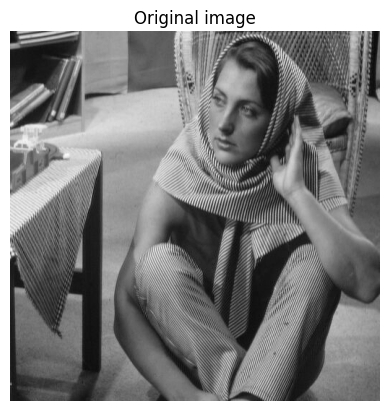

In [4]:
n = 512
name = 'barbara.jpg'
# use load_image from signal.py to load the image
f0 = load_image(name, n)
imageplot(f0, 'Original image')

## we don't use their noisy image, we use ours

In [5]:
# sigma = .08

# noise = sigma*np.random.standard_normal(f0.shape)

# f = f0 + noise

# imageplot(clamp(f), 'Noisy, SNR=' + str(snr(f0,f)) )

In [6]:
SNR = [0, 10, 20]
ys = []
y_snrs = []
y_noises = []
y_sig = []
plt.figure(figsize=(15,8))
for i in range(3):
    y, snr_tmp, sig, noiseT = add_noise(f0, SNR[i])
    ys.append(y)
    y_snrs.append(snr_tmp)
    y_noises.append(noiseT)
    y_sig.append(sig)

    # plot the noisy image above
    plt.subplot(2, 3, i+1)
    plt.imshow(y, cmap='gray')
    plt.title('Noisy image at SNR = ' + str(round(snr_tmp, 2)) + ' dB')
    plt.axis('off')

    # plot the noise below the image
    plt.subplot(2, 3, i+4)
    plt.imshow(noiseT, cmap='gray')
    plt.title('Noise')
    plt.axis('off')

plt.tight_layout()
plt.show()

## and will use the noisy image with SNR = 0 dB

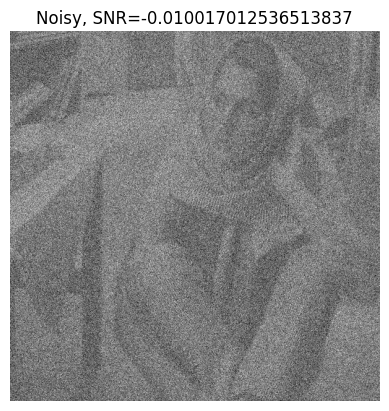

In [7]:
f = ys[0]
noise = y_noises[0]


imageplot(f, 'Noisy, SNR=' + str(snr(f0,f)) )

# <a> Hard thresholding </a>

## Display the function s0T(α) for T=1.

In [8]:
def thresh_hard(u,t):return u*(abs(u)>t)
alpha = np.linspace(-3,3,1000)
plt.plot(alpha, thresh_hard(alpha,1))
plt.axis('equal');

## Parameters for the orthogonal wavelet transform.

In [9]:
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551] 
h = h/np.linalg.norm(h)
Jmin = 2

## First we compute the wavelet coefficients a of the noisy image f.

In [10]:
a = perform_wavortho_transf(f,Jmin,+1,h)

## Display the noisy coefficients.

In [11]:
plot_wavelet(a,Jmin);

## Select the threshold value, that should be proportional to the noise level σ.

In [12]:
# T = 3*sigma
T = 3*y_sig[0]

## Hard threshold the coefficients below the noise level to obtain aT(m)=s0T(am).

In [13]:
aT = thresh_hard(a,T)

## Display the thresholded coefficients.

In [14]:
plot_wavelet(aT,Jmin);

## Reconstruct the image f~ from these noisy coefficients.

In [15]:
fHard = perform_wavortho_transf(aT,Jmin,-1,h)

## Display the denoising result.

In [16]:
imageplot(fHard, 'Hard, SNR=' + str(snr(f0,fHard)) )

# <a> Soft thresholding </a>

## Display the soft thresholding function s1T(α).

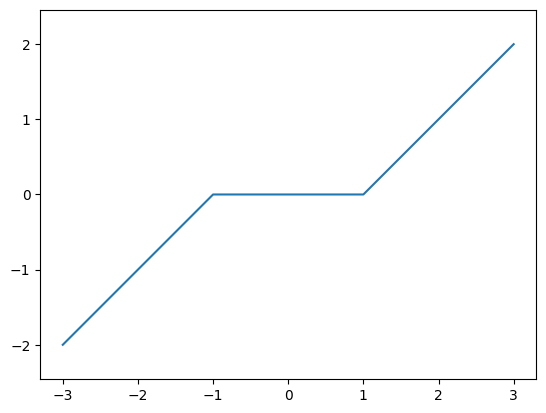

In [17]:
def thresh_soft(u,t):return np.maximum(1-t/abs(u), 0)*u
alpha = np.linspace(-3,3,1000)
plt.plot(alpha, thresh_soft(alpha,1))
plt.axis('equal');

## Select the threshold.

In [18]:
# T = 3/2*sigma
T = 3/2*y_sig[0]

## Perform the soft thresholding.

In [19]:
aT = thresh_soft(a,T)

## To slightly improve the soft thresholding performance, we do not threshold the coefficients corresponding to coarse scale wavelets.

In [20]:
aT[:2^Jmin:,:2^Jmin:] = a[:2^Jmin:,:2^Jmin:]

## Re-construct the soft thresholding estimator f~.

In [21]:
fSoft = perform_wavortho_transf(aT,Jmin,-1,h)

## Display the soft thresholding denoising result.

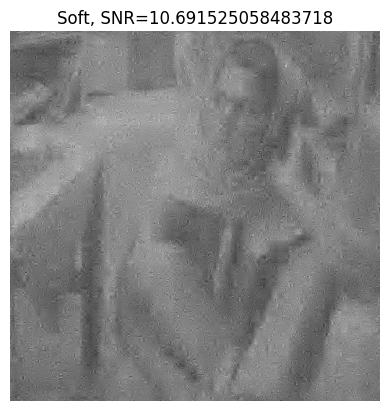

In [22]:
imageplot(fSoft, 'Soft, SNR=' + str(snr(f0,fSoft)) )

# <a> Translation Invariant Denoising with Cycle Spinning </a>

## Number m of translations along each direction so that M=m2.

In [23]:
m = 4

## Generate a set of shifts (δi)i.

In [24]:
[dY,dX] = np.meshgrid(np.arange(0,m),np.arange(0,m))
delta = np.concatenate( (dX.reshape(m*m,1), dY.reshape(m*m,1)), axis=1)

In [25]:
delta.shape

(16, 2)

## Initialize the denoised image f(0)=0.

In [26]:


fTI = np.zeros([n,n])
# T = 3*sigma
T = 3*y_sig[0]
for i in np.arange(0,m*m):
    fS = circshift(f,delta[i,:])
    a = perform_wavortho_transf(fS,Jmin,1,h)
    aT = thresh_hard(a,T)
    fS = perform_wavortho_transf(aT,Jmin,-1,h)
    fS = circshift(fS,-delta[i,:])
    fTI = i/(i+1.0)*fTI + 1.0/(i+1)*fS


In [27]:
fTI_tmp = np.zeros([n,n])
# T = 3*sigma
T = 3*y_sig[0]
for i in np.arange(0,m*m):
    fS = circshift(f,delta[i,:])
    # plot it 
    plt.subplot(m, m, i+1)
    plt.imshow(fS, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## the shift seems to be 1 pixel only so the difference is not visible but it gives a better result

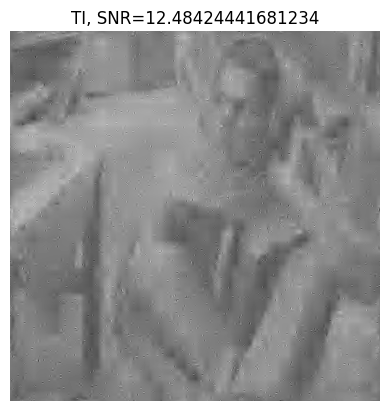

In [28]:
imageplot(fTI, 'TI, SNR=' + str(snr(f0,fTI)) )

---

<a style="font-size: 30pt; font-weight:bold"> 3. Discuss the parameters (wavelet type, number of level, type of thresholding) </a>

## function to denoise the image with the 3 methods on the 3 SNR levels

In [29]:
# put all the code below in a function so we can call it for different Jmin and h

def denoise(Jmin, h):

    # now try the hard thresholding with different values of T for the 3 noisy images

    plt.figure(figsize=(20,5))
    f_snr_gain_overall = []

    for i in range(3):
        f = ys[i]
        noise = y_noises[i]
        f_snr = y_snrs[i]

        coeffs = np.linspace(0, 10, 10)
        T = coeffs * y_sig[i]

        fHard = []
        fHard_SNRS = []

        for v in range(len(T)):
            a = perform_wavortho_transf(f,Jmin,+1,h)
            aT = thresh_hard(a,T[v])
            fHard.append(perform_wavortho_transf(aT,Jmin,-1,h))
            fHard_SNRS.append(snr(f0,fHard[v]))

        fHard_SNRS_Gain = np.array(fHard_SNRS) - f_snr

        fSoft = []
        fSoft_SNRS = []

        for v in range(len(T)):
            a = perform_wavortho_transf(f,Jmin,+1,h)
            aT = thresh_soft(a,T[v])
            aT[:2^Jmin:,:2^Jmin:] = a[:2^Jmin:,:2^Jmin:]
            fSoft.append(perform_wavortho_transf(aT,Jmin,-1,h))
            fSoft_SNRS.append(snr(f0,fSoft[v]))
        
        fSoft_SNRS_Gain = np.array(fSoft_SNRS) - f_snr

        fTIs = []
        fTI_SNRS = []

        for v in range(len(T)):
            fTI = np.zeros([n,n])

            for j in np.arange(0,m*m):
                fS = circshift(f,delta[j,:])
                a = perform_wavortho_transf(fS,Jmin,1,h)
                aT = thresh_hard(a,T[v])
                fS = perform_wavortho_transf(aT,Jmin,-1,h)
                fS = circshift(fS,-delta[j,:])
                fTI = j/(j+1.0)*fTI + 1.0/(j+1)*fS
            
            fTI_SNR = snr(f0,fTI)
            fTIs.append(fTI)
            fTI_SNRS.append(fTI_SNR)

        fTI_SNRS_Gain = np.array(fTI_SNRS) - f_snr

        f_snr_gain_overall.append([fHard_SNRS_Gain, fSoft_SNRS_Gain, fTI_SNRS_Gain])

        
        plt.subplot(1, 3, i+1)
        plt.plot(T, fHard_SNRS_Gain, label='Hard')
        plt.plot(T, fSoft_SNRS_Gain, label='Soft')
        plt.plot(T, fTI_SNRS_Gain, label='TI')
        plt.legend()
        plt.xlabel('T')
        plt.ylabel('SNR')
        plt.title('SNR Gain from SNR = ' + str(round(f_snr, 2)) + ' dB')


    plt.tight_layout()
    plt.show()


    # plot the images of before and after denoising for the 3 noisy images with the 3 methods at the best T

    plt.figure(figsize=(20,5))

    for i in range(3):
        f = ys[i]
        noise = y_noises[i]
        f_snr = y_snrs[i]

        # get the indexes of the best gain of SNR for each method
        best_hard = np.argmax(f_snr_gain_overall[i][0])
        best_soft = np.argmax(f_snr_gain_overall[i][1])
        best_ti = np.argmax(f_snr_gain_overall[i][2])

        coeffs = np.linspace(0, 10, 10)
        T = coeffs * y_sig[i]

        # get the best T for each method
        T_hard = T[best_hard]
        T_soft = T[best_soft]
        T_ti = T[best_ti]

        # Hard
        a = perform_wavortho_transf(f,Jmin,+1,h)
        aT = thresh_hard(a,T_hard)
        fHard = perform_wavortho_transf(aT,Jmin,-1,h)
        fHard_SNR = snr(f0,fHard)

        # Soft
        a = perform_wavortho_transf(f,Jmin,+1,h)
        aT = thresh_soft(a,T_soft)
        aT[:2^Jmin:,:2^Jmin:] = a[:2^Jmin:,:2^Jmin:]
        fSoft = perform_wavortho_transf(aT,Jmin,-1,h)
        fSoft_SNR = snr(f0,fSoft)

        # TI
        fTI = np.zeros([n,n])

        for j in np.arange(0,m*m):
            fS = circshift(f,delta[j,:])
            a = perform_wavortho_transf(fS,Jmin,1,h)
            aT = thresh_hard(a,T_ti)
            fS = perform_wavortho_transf(aT,Jmin,-1,h)
            fS = circshift(fS,-delta[j,:])
            fTI = j/(j+1.0)*fTI + 1.0/(j+1)*fS

        fTI_SNR = snr(f0,fTI)

        plt.subplot(3, 4, 4*i+1)
        plt.imshow(f, cmap='gray')
        plt.title('Noisy image at SNR = ' + str(round(f_snr, 2)) + ' dB')
        plt.axis('off')

        plt.subplot(3, 4, 4*i+2)
        plt.imshow(fHard, cmap='gray')
        plt.title('Hard, SNR = ' + str(round(fHard_SNR, 2)) + ' dB at T = ' + str(round(T_hard, 2)))
        plt.axis('off')

        plt.subplot(3, 4, 4*i+3)
        plt.imshow(fSoft, cmap='gray')
        plt.title('Soft, SNR = ' + str(round(fSoft_SNR, 2)) + ' dB at T = ' + str(round(T_soft, 2)))
        plt.axis('off')

        plt.subplot(3, 4, 4*i+4)
        plt.imshow(fTI, cmap='gray')
        plt.title('TI, SNR = ' + str(round(fTI_SNR, 2)) + ' dB at T = ' + str(round(T_ti, 2)))
        plt.axis('off')

    plt.tight_layout()
    plt.show()



In [30]:
print('Jmax = ' + str(int(np.log2(f0.shape[1])) - 1))

Jmax = 8


## results for 6 levels of wavelet decomposition

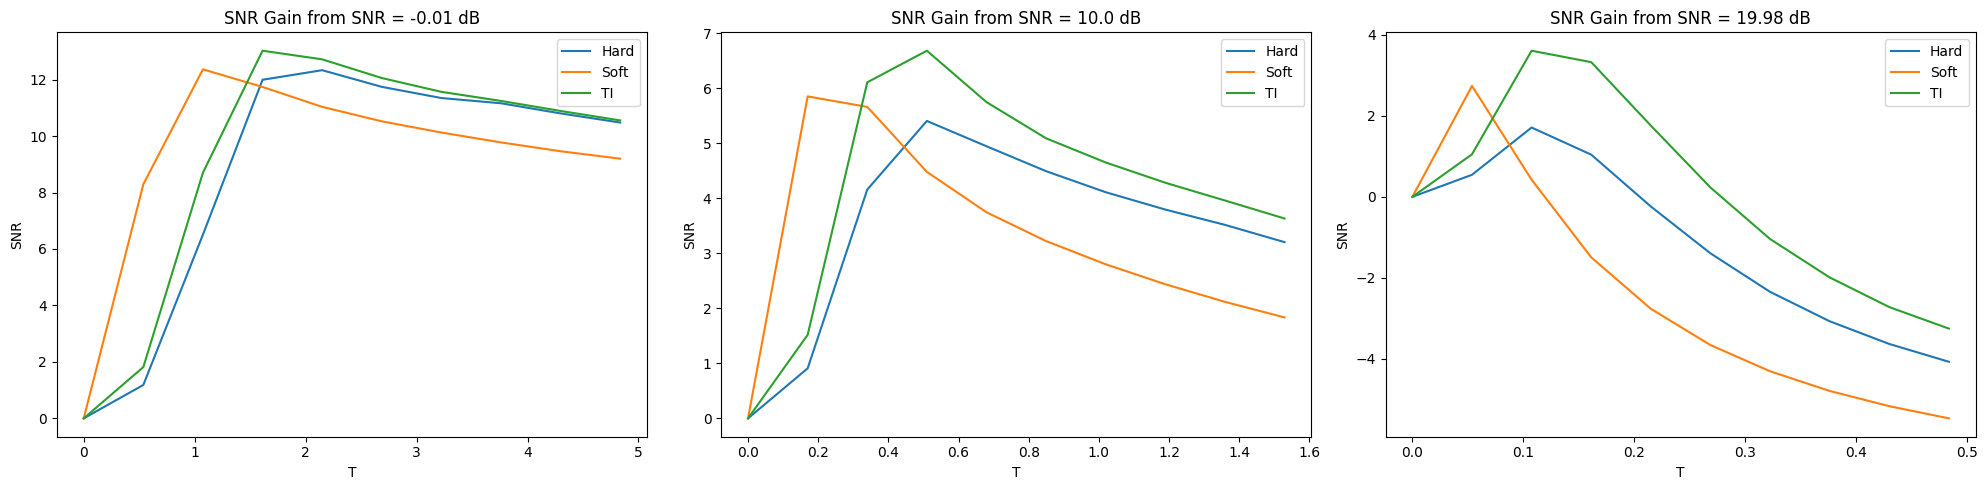

In [31]:
denoise(2, h)

## results for 2 levels of wavelet decomposition

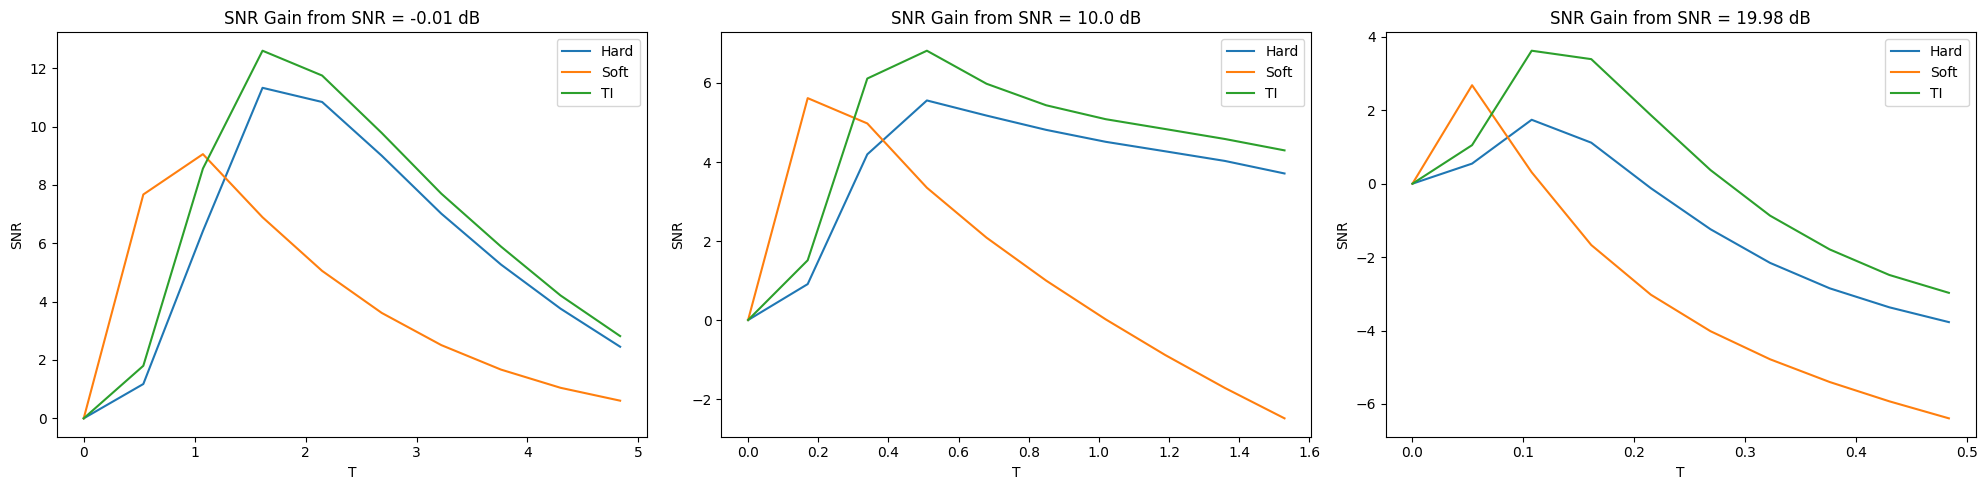

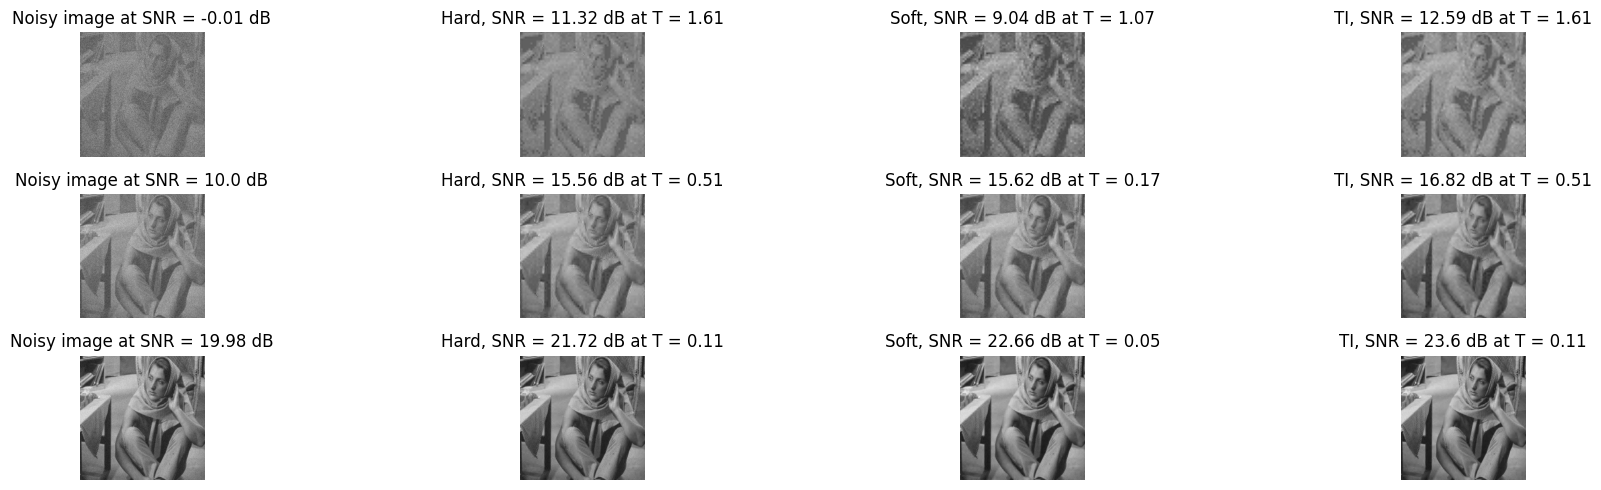

In [32]:
denoise(6, h)

## number of level : even if we loose very few SNR with less levels, the image is less pixelized (when starting from SNR = 0 dB) so i would prefer less levels when the image is very noisy

## Type of thresholding : hard < soft < translation invariant in terms of SNR gain (doing more translations (8 instead of 4) hasn't changed anything except the computation time)

## Wavelet type :

## there exist a library of wavelets families and their filters

In [33]:
import pywt

# Choose the wavelet family and name
wavelet_family = 'db'
wavelet_name = 'db2'

# Get high-pass filter coefficients
high_pass_filter = pywt.Wavelet(wavelet_name).dec_hi

print("High-pass filter coefficients for {}: {}".format(wavelet_name, high_pass_filter))

High-pass filter coefficients for db2: [-0.48296291314453416, 0.8365163037378079, -0.2241438680420134, -0.12940952255126037]


## however, it's not giving the ame high pass filter even when looking for the same as the one used in the numerical tour

In [34]:
h

array([ 0.        ,  0.48296291,  0.8365163 ,  0.22414387, -0.12940952])

## so unfortunately, we can't test other high pass filters from this family or other families